In [1]:
# import toolkit
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import pandas as pd
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import EarlyStopping

# Modelo da Amazon 

In [2]:
# import price and sentimental data
amazon_df = pd.read_csv('amazon_df.csv')
amazon_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
amazon_price_df = pd.read_csv('price/AMZN_1.csv')
amazon_df = pd.merge(amazon_df, amazon_price_df, how="outer", on=["Date", "Date"]).sort_values(by="Date", ascending=True)
print(amazon_df.shape)

(862, 12)


In [3]:
amazon_df.drop(columns=['Date'],inplace=True)
amazon_df['retorno'] = amazon_df['Close'].pct_change()
preprocessor = ColumnTransformer([('imputer',  KNNImputer(n_neighbors=1),['Open','Low','Close', 'Volume']),('MinMax', StandardScaler(),['Open','Low','Close', 'Volume', 'Positive', 'Negative','Neutral','Sentimental Score'])], remainder='passthrough')
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [4]:
amazon_df = amazon_df.dropna().reset_index()
y_2 = amazon_df['retorno']
X_2 = amazon_df.drop(columns=['retorno'])
X_2 = my_pipeline.fit_transform(X_2)
print(y_2.shape)
print(X_2.shape)

(542,)
(542, 16)


In [5]:
X_2train = []
y_2train = []
for i in range(10, 512):
    X_2train.append(X_2[i-10:i])
    y_2train.append(y_2[i])
X_2train, y_2train = np.array(X_2train), np.array(y_2train)

### RNN DA AMAZON

In [6]:
def tanise_model():
    #normalizar o x train
    model = models.Sequential()
    model.add(layers.LSTM(100, return_sequences=True, activation='tanh'))
    model.add(layers.LSTM(100, return_sequences=False, activation='tanh'))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(30, activation='linear'))
    model.compile(loss='mse', 
                  optimizer=RMSprop(learning_rate=0.03), 
                  metrics=['mae'])
    
    return model

In [7]:
modelo_2 = tanise_model()
callback = EarlyStopping(monitor='loss', patience=10)
fitted_2 = modelo_2.fit(X_2train, y_2train, epochs = 150, batch_size = 80, callbacks=callback)

2021-08-10 19:05:37.532182: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-10 19:05:37.770217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
7/7 [==============================] - 8s 62ms/step - loss: 2.1557 - mae: 0.9247
Epoch 2/150
7/7 [==============================] - 0s 68ms/step - loss: 0.0013 - mae: 0.0278
Epoch 3/150
7/7 [==============================] - 0s 59ms/step - loss: 6.3727e-04 - mae: 0.0191
Epoch 4/150
7/7 [==============================] - 0s 66ms/step - loss: 4.3810e-04 - mae: 0.0153
Epoch 5/150
7/7 [==============================] - 1s 88ms/step - loss: 3.8343e-04 - mae: 0.0141
Epoch 6/150
7/7 [==============================] - 0s 56ms/step - loss: 3.7316e-04 - mae: 0.0138
Epoch 7/150
7/7 [==============================] - 0s 61ms/step - loss: 6.7222e-04 - mae: 0.0190
Epoch 8/150
7/7 [==============================] - 0s 60ms/step - loss: 4.2034e-04 - mae: 0.0149
Epoch 9/150
7/7 [==============================] - 1s 85ms/step - loss: 3.8022e-04 - mae: 0.0140
Epoch 10/150
7/7 [==============================] - 0s 61ms/step - loss: 5.9602e-04 - mae: 0.0179
Epoch 11/150
7/7 [===================

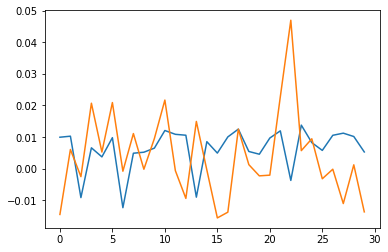

In [8]:
X_2test = []
y_2test = []
for i in range(512, len(X_2)):
    X_2test.append(X_2[i-10:i])
    y_2test.append(y_2[i])
X_2test = np.array(X_2test)
previsao_2 = modelo_2.predict(X_2test[:1])
plt.plot(previsao_2[0])
plt.plot(y_2test)

In [111]:
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_amaz = []
for i in range(1,31):
    final_array_amaz.append([i,y_2test[i-1]])
print(final_array_amaz)
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_amazr = []
for i in range(1,31):
    final_array_amazr.append([i,previsao_2[0][i-1]])
print(final_array_amazr)

[[1, -0.014526940449806403], [2, 0.006027581005307203], [3, -0.0025606356002577657], [4, 0.020669133865531597], [5, 0.005220349326898521], [6, 0.020876827345878368], [7, -0.0008418264841100198], [8, 0.011067200346823292], [9, -0.00021875366796175744], [10, 0.009494201556198512], [11, 0.02166458970792773], [12, -0.0006706583687869916], [13, -0.009446769888951101], [14, 0.014904625583759046], [15, -0.000462102625423344], [16, -0.015622945510225916], [17, -0.013806613915329335], [18, 0.012474035410231954], [19, 0.001234069651482983], [20, -0.00231428574467063], [21, -0.0020900019719781726], [22, 0.0227237667847342], [23, 0.04692707191113055], [24, 0.005669630620418253], [25, 0.009422177597960824], [26, -0.003234655072653414], [27, -0.00021241375655556283], [28, -0.0110768825099119], [29, 0.0011747081804083237], [30, -0.013711126967133613]]
[[1, 0.0099112205], [2, 0.010238368], [3, -0.009191826], [4, 0.0065579433], [5, 0.0036906246], [6, 0.009765483], [7, -0.01238619], [8, 0.00484737], [9,

y_2test = [-0.014526940449806403,
 0.006027581005307203,
 -0.0025606356002577657,
 0.020669133865531597,
 0.005220349326898521,
 0.020876827345878368,
 -0.0008418264841100198,
 0.011067200346823292,
 -0.00021875366796175744,
 0.009494201556198512,
 0.02166458970792773,
 -0.0006706583687869916,
 -0.009446769888951101,
 0.014904625583759046,
 -0.000462102625423344,
 -0.015622945510225916,
 -0.013806613915329335,
 0.012474035410231954,
 0.001234069651482983,
 -0.00231428574467063,
 -0.0020900019719781726,
 0.0227237667847342,
 0.04692707191113055,
 0.005669630620418253,
 0.009422177597960824,
 -0.003234655072653414,
 -0.00021241375655556283,
 -0.0110768825099119,
 0.0011747081804083237,
 -0.013711126967133613]

previsao_2[0] =array([ 0.00991122,  0.01023837, -0.00919183,  0.00655794,  0.00369062,
        0.00976548, -0.01238619,  0.00484737,  0.00517009,  0.00645885,
        0.01203675,  0.01083167,  0.01054235, -0.0090538 ,  0.00850341,
        0.0048915 ,  0.01001052,  0.01247112,  0.0053985 ,  0.00453537,
        0.0096579 ,  0.01192789, -0.00375471,  0.01374026,  0.00820269,
        0.00573999,  0.01052291,  0.01119381,  0.01013582,  0.00525059],
      dtype=float32)

### VALORES DA AMAZON

# Modelos para as outras

In [13]:
# import sentimental data
gme_df = pd.read_csv('gme_df.csv')
kodak_df = pd.read_csv('kodak_df.csv')
facebook_df = pd.read_csv('fb_df.csv')
apple_df = pd.read_csv('new_data/aapl_df.csv')
baba_df = pd.read_csv('new_data/baba_df.csv')
goog_df = pd.read_csv('new_data/goog_df.csv')
jnj_df = pd.read_csv('new_data/jnj_df.csv')
pfe_df = pd.read_csv('new_data/pfe_df.csv')
tsla_df = pd.read_csv('new_data/tsla_df.csv')

In [14]:
# renaming columns
gme_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
kodak_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
facebook_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
goog_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
apple_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
baba_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
jnj_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
pfe_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
tsla_df.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)

# dropping columns


gme_df.drop(columns=['Unnamed: 0'], inplace=True)
kodak_df.drop(columns=['Unnamed: 0'], inplace=True)
facebook_df.drop(columns=['Unnamed: 0'], inplace=True)
apple_df.drop(columns=['Unnamed: 0'], inplace=True)
goog_df.drop(columns=['Unnamed: 0'], inplace=True)
baba_df.drop(columns=['Unnamed: 0'], inplace=True)
jnj_df.drop(columns=['Unnamed: 0'], inplace=True)
pfe_df.drop(columns=['Unnamed: 0'], inplace=True)
tsla_df.drop(columns=['Unnamed: 0'], inplace=True)

In [15]:
# import price data
gme_price_df = pd.read_csv('price/GME_1.csv')
kodak_price_df = pd.read_csv('price/KODK_1.csv')
facebook_price_df = pd.read_csv('price/FB_1.csv')
apple_price_df = pd.read_csv('price/AAPL.csv')
baba_price_df = pd.read_csv('price/BABA.csv')
goog_price_df = pd.read_csv('price/GOOG.csv')
jnj_price_df = pd.read_csv('price/JNJ.csv')
pfe_price_df = pd.read_csv('price/PFE.csv')
tsla_price_df = pd.read_csv('price/TSLA.csv')

In [16]:
gme_df = pd.merge(gme_df, gme_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
kodak_df = pd.merge(kodak_df, kodak_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
facebook_df = pd.merge(facebook_df, facebook_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
apple_df = pd.merge(apple_df, apple_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
baba_df = pd.merge(baba_df, baba_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
goog_df = pd.merge(goog_df, goog_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
jnj_df = pd.merge(jnj_df, jnj_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
pfe_df = pd.merge(pfe_df, pfe_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)
tsla_df = pd.merge(tsla_df, tsla_price_df, how="outer", on=["Date", "Date"] ).sort_values(by="Date", ascending=True)

In [17]:
facebook_df.drop(columns=['Date'],inplace=True)
kodak_df.drop(columns=['Date'],inplace=True)
gme_df.drop(columns=['Date'],inplace=True)
apple_df.drop(columns=['Date'],inplace=True)
goog_df.drop(columns=['Date'],inplace=True)
baba_df.drop(columns=['Date'],inplace=True)
jnj_df.drop(columns=['Date'],inplace=True)
pfe_df.drop(columns=['Date'],inplace=True)
tsla_df.drop(columns=['Date'],inplace=True)

In [18]:
facebook_df['retorno'] = facebook_df['Close'].pct_change()
kodak_df['retorno'] = kodak_df['Close'].pct_change()
gme_df['retorno'] = gme_df['Close'].pct_change()
apple_df['retorno'] = apple_df['Close'].pct_change()
goog_df['retorno'] = goog_df['Close'].pct_change()
baba_df['retorno'] = baba_df['Close'].pct_change()
jnj_df['retorno'] = jnj_df['Close'].pct_change()
pfe_df['retorno'] = pfe_df['Close'].pct_change()
tsla_df['retorno'] = tsla_df['Close'].pct_change()

In [19]:
apple_df = apple_df.dropna().reset_index()#1
gme_df = gme_df.dropna().reset_index() #3
kodak_df = kodak_df.dropna().reset_index() #4
facebook_df = facebook_df.dropna().reset_index()#5
goog_df = goog_df.dropna().reset_index() #6
jnj_df = jnj_df.dropna().reset_index() #7
pfe_df = pfe_df.dropna().reset_index() #8
tsla_df = tsla_df.dropna().reset_index() #9
baba_df = baba_df.dropna().reset_index() #10

In [20]:
my_pipeline1 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline3 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline4 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline5 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline6 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline7 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline8 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline9 = Pipeline(steps=[('preprocessor', preprocessor)])
my_pipeline10 = Pipeline(steps=[('preprocessor', preprocessor)])

In [21]:
y_1 = apple_df['retorno']
y_3 = gme_df['retorno']
y_4 = kodak_df['retorno']
y_5 = facebook_df['retorno']
y_6 = goog_df['retorno']
y_7 = jnj_df['retorno']
y_8 = pfe_df['retorno']
y_9 = tsla_df['retorno']
y_10 = baba_df['retorno']

In [22]:
X_1 = apple_df.drop(columns=['retorno'])
X_3 = gme_df.drop(columns=['retorno'])
X_4 = kodak_df.drop(columns=['retorno'])
X_5 = facebook_df.drop(columns=['retorno'])
X_6 = goog_df.drop(columns=['retorno'])
X_7 = jnj_df.drop(columns=['retorno'])
X_8 = pfe_df.drop(columns=['retorno'])
X_9 = tsla_df.drop(columns=['retorno'])
X_10 = baba_df.drop(columns=['retorno'])

In [23]:
X_1 = my_pipeline1.fit_transform(X_1)
X_3 = my_pipeline3.fit_transform(X_3)
X_4 = my_pipeline4.fit_transform(X_4)
X_5 = my_pipeline5.fit_transform(X_5)
X_6 = my_pipeline6.fit_transform(X_6)
X_7 = my_pipeline7.fit_transform(X_7)
X_8 = my_pipeline8.fit_transform(X_8)
X_9 = my_pipeline9.fit_transform(X_9)
X_10 = my_pipeline10.fit_transform(X_10)

In [24]:
X_1train = []
y_1train = []
for i in range(10, 547):
    X_1train.append(X_1[i-10:i])
    y_1train.append(y_1[i])
X_3train = []
y_3train = []
for i in range(10, 303):
    X_3train.append(X_3[i-10:i])
    y_3train.append(y_3[i])
X_4train = []
y_4train = []
for i in range(10, 75):
    X_4train.append(X_4[i-10:i])
    y_4train.append(y_4[i])
X_5train = []
y_5train = []
for i in range(10, 597):
    X_5train.append(X_5[i-10:i])
    y_5train.append(y_5[i])    
X_6train = []
y_6train = []
for i in range(10, 547):
    X_6train.append(X_6[i-10:i])
    y_6train.append(y_6[i])
X_7train = []
y_7train = []
for i in range(10, 426):
    X_7train.append(X_7[i-10:i])
    y_7train.append(y_7[i])
X_8train = []
y_8train = []
for i in range(10, 456):
    X_8train.append(X_8[i-10:i])
    y_8train.append(y_8[i])
X_9train = []
y_9train = []
for i in range(10, 547):
    X_9train.append(X_9[i-10:i])
    y_9train.append(y_9[i])
X_10train = []
y_10train = []
for i in range(10, 499):
    X_10train.append(X_10[i-10:i])
    y_10train.append(y_10[i])

In [25]:
X_1train, y_1train = np.array(X_1train), np.array(y_1train)
X_3train, y_3train = np.array(X_3train), np.array(y_3train)
X_4train, y_4train = np.array(X_4train), np.array(y_4train)
X_5train, y_5train = np.array(X_5train), np.array(y_5train)
X_6train, y_6train = np.array(X_6train), np.array(y_6train)
X_7train, y_7train = np.array(X_7train), np.array(y_7train)
X_8train, y_8train = np.array(X_8train), np.array(y_8train)
X_9train, y_9train = np.array(X_9train), np.array(y_9train)
X_10train, y_10train = np.array(X_10train), np.array(y_10train)

Epoch 1/150
7/7 [==============================] - 11s 59ms/step - loss: 1.0904 - mae: 0.5137
Epoch 2/150
7/7 [==============================] - 0s 57ms/step - loss: 0.0020 - mae: 0.0342
Epoch 3/150
7/7 [==============================] - 0s 55ms/step - loss: 8.5229e-04 - mae: 0.0215
Epoch 4/150
7/7 [==============================] - 0s 59ms/step - loss: 6.0625e-04 - mae: 0.0175
Epoch 5/150
7/7 [==============================] - 0s 57ms/step - loss: 5.5945e-04 - mae: 0.0165
Epoch 6/150
7/7 [==============================] - 0s 58ms/step - loss: 5.5369e-04 - mae: 0.0163
Epoch 7/150
7/7 [==============================] - 0s 58ms/step - loss: 5.5370e-04 - mae: 0.0163
Epoch 8/150
7/7 [==============================] - 0s 61ms/step - loss: 7.4686e-04 - mae: 0.0192
Epoch 9/150
7/7 [==============================] - 0s 50ms/step - loss: 6.9135e-04 - mae: 0.0191
Epoch 10/150
7/7 [==============================] - 1s 84ms/step - loss: 5.8211e-04 - mae: 0.0172
Epoch 11/150
7/7 [==================

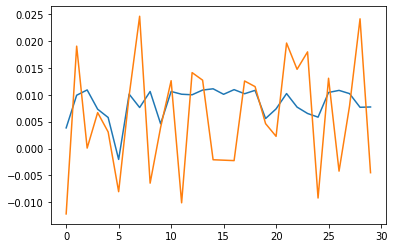

In [26]:
modelo_1 = tanise_model()
callback = EarlyStopping(monitor='loss', patience=10)
fitted_1 = modelo_1.fit(X_1train, y_1train, epochs = 150, batch_size = 80, callbacks=callback)
X_1test = []
y_1test = []
for i in range(547, len(X_1)):
    X_1test.append(X_1[i-10:i])
    y_1test.append(y_1[i])
X_1test = np.array(X_1test)
previsao_1 = modelo_1.predict(X_1test[:1])
plt.plot(previsao_1[0])
plt.plot(y_1test)

In [104]:
y_1test
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array = []
for i in range(1,31):
    final_array.append([i,y_1test[i-1]])
final_array
    

[[1, -0.012154139395007313],
 [2, 0.019022166559055975],
 [3, 7.945139629006448e-05],
 [4, 0.0066719327061957046],
 [5, 0.003077161087438496],
 [6, -0.00802325702118245],
 [7, 0.009832668763525065],
 [8, 0.024577913552578545],
 [9, -0.006437740384699686],
 [10, 0.003933928642679829],
 [11, 0.012600841079968284],
 [12, -0.010091711359132227],
 [13, 0.014103911108376721],
 [14, 0.012698357044814257],
 [15, -0.002089855114387973],
 [16, -0.0021689849869261923],
 [17, -0.00224872980678148],
 [18, 0.012546000760933262],
 [19, 0.011500245331623304],
 [20, 0.0046211756352296796],
 [21, 0.002263416642797056],
 [22, 0.01959643299833358],
 [23, 0.01471847284778427],
 [24, 0.01795523852305836],
 [25, -0.009199707848613237],
 [26, 0.013054977977341231],
 [27, -0.004203711720665804],
 [28, 0.007889269132515198],
 [29, 0.024100484218248397],
 [30, -0.004492109932034749]]

In [107]:

#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array = []
for i in range(1,31):
    final_array.append([i,y_1test[i-1]])
print(final_array)
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_r = []
for i in range(1,31):
    final_array_r.append([i,previsao_1[0][i-1]])
print(final_array_r)



[[1, -0.012154139395007313], [2, 0.019022166559055975], [3, 7.945139629006448e-05], [4, 0.0066719327061957046], [5, 0.003077161087438496], [6, -0.00802325702118245], [7, 0.009832668763525065], [8, 0.024577913552578545], [9, -0.006437740384699686], [10, 0.003933928642679829], [11, 0.012600841079968284], [12, -0.010091711359132227], [13, 0.014103911108376721], [14, 0.012698357044814257], [15, -0.002089855114387973], [16, -0.0021689849869261923], [17, -0.00224872980678148], [18, 0.012546000760933262], [19, 0.011500245331623304], [20, 0.0046211756352296796], [21, 0.002263416642797056], [22, 0.01959643299833358], [23, 0.01471847284778427], [24, 0.01795523852305836], [25, -0.009199707848613237], [26, 0.013054977977341231], [27, -0.004203711720665804], [28, 0.007889269132515198], [29, 0.024100484218248397], [30, -0.004492109932034749]]
[[1, 0.0038309265], [2, 0.009900422], [3, 0.010881928], [4, 0.007304075], [5, 0.005764814], [6, -0.0020281803], [7, 0.010103725], [8, 0.007618288], [9, 0.01059

In [89]:
apple_df.iloc[-1]['Close']
forecast = previsao_1[0]
apple_price_forecast = []
last = apple_df.iloc[-1]['Close']
for i in forecast:
    last = last * (1 + i)
    print(last)
    apple_price_forecast.append(last)
apple_price_forecast

149.04881167682404
150.52445778650193
152.16245406762278
153.27386007079812
154.15745537953143
153.8447962675463
155.3992017658544
156.5830776466967
158.2416433166297
158.96873026073933
160.65354469619203
162.2738550472869
163.89424440757998
165.67429766671407
167.51269184118712
169.20011093218415
171.05116021597462
172.7922211523475
174.65988039239173
175.63261409688357
176.92554242861462
178.73162694765452
180.1070607260035
181.27955244545848
182.3355762193847
184.23436145295204
186.22415660819988
188.12368036261856
189.56478521674336
191.02784183346975


[149.04881167682404,
 150.52445778650193,
 152.16245406762278,
 153.27386007079812,
 154.15745537953143,
 153.8447962675463,
 155.3992017658544,
 156.5830776466967,
 158.2416433166297,
 158.96873026073933,
 160.65354469619203,
 162.2738550472869,
 163.89424440757998,
 165.67429766671407,
 167.51269184118712,
 169.20011093218415,
 171.05116021597462,
 172.7922211523475,
 174.65988039239173,
 175.63261409688357,
 176.92554242861462,
 178.73162694765452,
 180.1070607260035,
 181.27955244545848,
 182.3355762193847,
 184.23436145295204,
 186.22415660819988,
 188.12368036261856,
 189.56478521674336,
 191.02784183346975]

In [92]:
forecast_2 =previsao_2[0]
amazon_price_forecast = []
last = amazon_df.iloc[-1]['Close']
for i in forecast_2:
    last = last * (1 + i)
    print(last)
    amazon_price_forecast.append(last)
amazon_price_forecast

3667.1895744692424
3704.7356110937276
3670.6823260327556
3694.7544525970347
3708.3904043061802
3744.6046293846625
3698.223245817708
3716.1499025586027
3735.3627324691656
3759.488868295537
3804.740903283605
3845.952618536535
3886.498003864671
3851.31041638724
3884.059684438728
3903.058561907327
3942.1302149579865
3991.2930117815667
4012.840017376747
4031.039714952001
4069.971111577811
4118.517285497014
4103.053448089001
4159.430469891547
4193.548991237851
4217.619907497449
4262.001547787009
4309.7095834639895
4353.39203266557
4376.249908999106


[3667.1895744692424,
 3704.7356110937276,
 3670.6823260327556,
 3694.7544525970347,
 3708.3904043061802,
 3744.6046293846625,
 3698.223245817708,
 3716.1499025586027,
 3735.3627324691656,
 3759.488868295537,
 3804.740903283605,
 3845.952618536535,
 3886.498003864671,
 3851.31041638724,
 3884.059684438728,
 3903.058561907327,
 3942.1302149579865,
 3991.2930117815667,
 4012.840017376747,
 4031.039714952001,
 4069.971111577811,
 4118.517285497014,
 4103.053448089001,
 4159.430469891547,
 4193.548991237851,
 4217.619907497449,
 4262.001547787009,
 4309.7095834639895,
 4353.39203266557,
 4376.249908999106]

previsao_1[0] =array([ 0.00383093,  0.00990042,  0.01088193,  0.00730408,  0.00576481,
       -0.00202818,  0.01010372,  0.00761829,  0.01059224,  0.00459479,
        0.0105984 ,  0.01008574,  0.00998552,  0.01086099,  0.01109644,
        0.01007338,  0.01094   ,  0.0101786 ,  0.0108087 ,  0.0055693 ,
        0.00736155,  0.01020816,  0.00769553,  0.00650997,  0.00582539,
        0.01041368,  0.01080035,  0.0102002 ,  0.00766041,  0.00771798],
      dtype=float32)

y_1test =[-0.012154139395007313,
 0.019022166559055975,
 7.945139629006448e-05,
 0.0066719327061957046,
 0.003077161087438496,
 -0.00802325702118245,
 0.009832668763525065,
 0.024577913552578545,
 -0.006437740384699686,
 0.003933928642679829,
 0.012600841079968284,
 -0.010091711359132227,
 0.014103911108376721,
 0.012698357044814257,
 -0.002089855114387973,
 -0.0021689849869261923,
 -0.00224872980678148,
 0.012546000760933262,
 0.011500245331623304,
 0.0046211756352296796,
 0.002263416642797056,
 0.01959643299833358,
 0.01471847284778427,
 0.01795523852305836,
 -0.009199707848613237,
 0.013054977977341231,
 -0.004203711720665804,
 0.007889269132515198,
 0.024100484218248397,
 -0.004492109932034749]

Epoch 1/150
4/4 [==============================] - 6s 42ms/step - loss: 4.8847 - mae: 1.4375
Epoch 2/150
4/4 [==============================] - 0s 39ms/step - loss: 0.0298 - mae: 0.0951
Epoch 3/150
4/4 [==============================] - 0s 42ms/step - loss: 0.0285 - mae: 0.0888
Epoch 4/150
4/4 [==============================] - 0s 43ms/step - loss: 0.0280 - mae: 0.0875
Epoch 5/150
4/4 [==============================] - 0s 38ms/step - loss: 0.0278 - mae: 0.0871
Epoch 6/150
4/4 [==============================] - 0s 44ms/step - loss: 0.0277 - mae: 0.0865
Epoch 7/150
4/4 [==============================] - 0s 56ms/step - loss: 0.0277 - mae: 0.0867
Epoch 8/150
4/4 [==============================] - 0s 60ms/step - loss: 0.0276 - mae: 0.0874
Epoch 9/150
4/4 [==============================] - 0s 64ms/step - loss: 0.0277 - mae: 0.0869
Epoch 10/150
4/4 [==============================] - 0s 80ms/step - loss: 0.0277 - mae: 0.0887
Epoch 11/150
4/4 [==============================] - 0s 79ms/step - lo

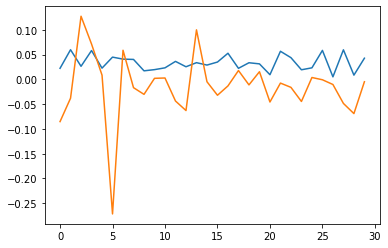

In [36]:
modelo_3 = tanise_model()
callback = EarlyStopping(monitor='loss', patience=10)
fitted_3 = modelo_3.fit(X_3train, y_3train, epochs = 150, batch_size = 75, callbacks=callback)
X_3test = []
y_3test = []
for i in range(303, len(X_3)):
    X_3test.append(X_3[i-30:i])
    y_3test.append(y_3[i])
X_3test = np.array(X_3test)
previsao_3 = modelo_3.predict(X_3test[:1])
plt.plot(previsao_3[0])
plt.plot(y_3test)

In [93]:
forecast_3 = previsao_3[0]
gme_price_forecast = []
last = gme_df.iloc[-1]['Close']
for i in forecast_3:
    last = last * (1 + i)
    print(last)
    gme_price_forecast.append(last)
gme_price_forecast

170.97891620738
177.81756059814552
181.35558483143095
188.68152864097027
194.34699971052905
199.67211872863632
209.0425066590483
214.68380778647398
222.444796399627
221.49474116483623
220.2623666022253
227.17929636855484
232.12107007515226
237.5219764973475
238.7763993883855
246.96119765608475
263.0395048953969
265.8087431760941
271.5517267110589
280.98347447190446
281.8391424620075
290.77968307466944
298.5051164001183
305.4425743593642
309.9439813510684
325.5934938383838
337.00060343060744
345.5342116557834
365.1010457574642
370.5855740540408


[170.97891620738,
 177.81756059814552,
 181.35558483143095,
 188.68152864097027,
 194.34699971052905,
 199.67211872863632,
 209.0425066590483,
 214.68380778647398,
 222.444796399627,
 221.49474116483623,
 220.2623666022253,
 227.17929636855484,
 232.12107007515226,
 237.5219764973475,
 238.7763993883855,
 246.96119765608475,
 263.0395048953969,
 265.8087431760941,
 271.5517267110589,
 280.98347447190446,
 281.8391424620075,
 290.77968307466944,
 298.5051164001183,
 305.4425743593642,
 309.9439813510684,
 325.5934938383838,
 337.00060343060744,
 345.5342116557834,
 365.1010457574642,
 370.5855740540408]

In [90]:
gme_df.iloc[-1]['Close']

166.820007

y_3test = [-0.0852465910305622,
 -0.03803544916820878,
 0.12743601575359964,
 0.07139026922644653,
 0.00853332666666673,
 -0.2715824945239457,
 0.058759458499748174,
 -0.01671378274987212,
 -0.03024756772796744,
 0.0021123640449438597,
 0.0027806206988356674,
 -0.04369600239180649,
 -0.0629034307346179,
 0.09996506213417833,
 -0.004809428443087738,
 -0.032050689013416456,
 -0.013188276700939916,
 0.017851200846050297,
 -0.011113692848768952,
 0.015459000012827184,
 -0.045671047191888636,
 -0.0074867830911784505,
 -0.016121895024188815,
 -0.0445980862356995,
 0.003776360982348681,
 -0.0007838279657271796,
 -0.010354003249573918,
 -0.04856011624834866,
 -0.06908809917903036,
 -0.004772628706974924]

previsao_3[0] = array([0.02233301, 0.05983773, 0.02640971, 0.0581683 , 0.02270181,
       0.04492044, 0.04087638, 0.04026679, 0.01726274, 0.01966101,
       0.0232937 , 0.03630141, 0.02545638, 0.03372309, 0.02887817,
       0.03497368, 0.0527494 , 0.02232202, 0.0335694 , 0.03129945,
       0.00942895, 0.05671417, 0.04382621, 0.01936078, 0.02331826,
       0.058484  , 0.00510357, 0.05966189, 0.00857744, 0.04274287],
      dtype=float32)

In [110]:
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_gme = []
for i in range(1,31):
    final_array_gme.append([i,y_3test[i-1]])
print(final_array_gme)
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_gmer = []
for i in range(1,31):
    final_array_gmer.append([i,previsao_3[0][i-1]])
print(final_array_gmer)

[[1, -0.0852465910305622], [2, -0.03803544916820878], [3, 0.12743601575359964], [4, 0.07139026922644653], [5, 0.00853332666666673], [6, -0.2715824945239457], [7, 0.058759458499748174], [8, -0.01671378274987212], [9, -0.03024756772796744], [10, 0.0021123640449438597], [11, 0.0027806206988356674], [12, -0.04369600239180649], [13, -0.0629034307346179], [14, 0.09996506213417833], [15, -0.004809428443087738], [16, -0.032050689013416456], [17, -0.013188276700939916], [18, 0.017851200846050297], [19, -0.011113692848768952], [20, 0.015459000012827184], [21, -0.045671047191888636], [22, -0.0074867830911784505], [23, -0.016121895024188815], [24, -0.0445980862356995], [25, 0.003776360982348681], [26, -0.0007838279657271796], [27, -0.010354003249573918], [28, -0.04856011624834866], [29, -0.06908809917903036], [30, -0.004772628706974924]]
[[1, 0.024930518], [2, 0.039997004], [3, 0.019896934], [4, 0.04039547], [5, 0.030026633], [6, 0.027400058], [7, 0.046928875], [8, 0.026986383], [9, 0.036150787], 

In [160]:
gme_df1 = pd.read_csv('gme_df.csv')
gme_df1.rename({'0':'Date', '1':'Positive', '2':'Neutral', '3':'Negative', '4':'Sentimental Score'}, axis=1, inplace=True)
gme_df1_price_df = pd.read_csv('price/GME_1.csv')
gme_df1 = pd.merge(gme_df1, gme_df1_price_df, how="outer", on=["Date", "Date"]).sort_values(by="Date", ascending=False)
gme_df1 = gme_df1.sort_values(by='Date')
len(np.array(gme_df1['Date']))
len(np.array(gme_df1['Positive']))
new_array = []
for i in range(726):
    mini_array = [ np.array(gme_df1['Date'])[i] , np.array(gme_df1['Negative'])[i] ]
    new_array.append(mini_array)
new_array

[['2019-01-16', nan],
 ['2019-01-17', nan],
 ['2019-01-18', nan],
 ['2019-01-22', nan],
 ['2019-01-23', nan],
 ['2019-01-24', nan],
 ['2019-01-25', nan],
 ['2019-01-28', nan],
 ['2019-01-29', nan],
 ['2019-01-30', nan],
 ['2019-01-31', nan],
 ['2019-02-01', nan],
 ['2019-02-04', nan],
 ['2019-02-05', nan],
 ['2019-02-06', nan],
 ['2019-02-07', nan],
 ['2019-02-08', nan],
 ['2019-02-11', nan],
 ['2019-02-12', nan],
 ['2019-02-13', nan],
 ['2019-02-14', nan],
 ['2019-02-15', nan],
 ['2019-02-19', nan],
 ['2019-02-20', nan],
 ['2019-02-21', nan],
 ['2019-02-22', nan],
 ['2019-02-25', nan],
 ['2019-02-26', nan],
 ['2019-02-27', nan],
 ['2019-02-28', nan],
 ['2019-03-01', nan],
 ['2019-03-04', nan],
 ['2019-03-05', nan],
 ['2019-03-06', nan],
 ['2019-03-07', nan],
 ['2019-03-08', nan],
 ['2019-03-11', nan],
 ['2019-03-12', nan],
 ['2019-03-13', nan],
 ['2019-03-14', nan],
 ['2019-03-15', nan],
 ['2019-03-18', nan],
 ['2019-03-19', nan],
 ['2019-03-20', nan],
 ['2019-03-21', nan],
 ['2019-03

[['2019-01-16', nan],
 ['2019-01-17', nan],
 ['2019-01-18', nan],
 ['2019-01-22', nan],
 ['2019-01-23', nan],
 ['2019-01-24', nan],
 ['2019-01-25', nan],
 ['2019-01-28', nan],
 ['2019-01-29', nan],
 ['2019-01-30', nan],
 ['2019-01-31', nan],
 ['2019-02-01', nan],
 ['2019-02-04', nan],
 ['2019-02-05', nan],
 ['2019-02-06', nan],
 ['2019-02-07', nan],
 ['2019-02-08', nan],
 ['2019-02-11', nan],
 ['2019-02-12', nan],
 ['2019-02-13', nan],
 ['2019-02-14', nan],
 ['2019-02-15', nan],
 ['2019-02-19', nan],
 ['2019-02-20', nan],
 ['2019-02-21', nan],
 ['2019-02-22', nan],
 ['2019-02-25', nan],
 ['2019-02-26', nan],
 ['2019-02-27', nan],
 ['2019-02-28', nan],
 ['2019-03-01', nan],
 ['2019-03-04', nan],
 ['2019-03-05', nan],
 ['2019-03-06', nan],
 ['2019-03-07', nan],
 ['2019-03-08', nan],
 ['2019-03-11', nan],
 ['2019-03-12', nan],
 ['2019-03-13', nan],
 ['2019-03-14', nan],
 ['2019-03-15', nan],
 ['2019-03-18', nan],
 ['2019-03-19', nan],
 ['2019-03-20', nan],
 ['2019-03-21', nan],
 ['2019-03

726

In [118]:
np.array(gme_df1['Date'])[i]

IndexError: index 423 is out of bounds for axis 0 with size 423

Epoch 1/150
6/6 [==============================] - 8s 130ms/step - loss: 4.9152 - mae: 1.3684
Epoch 2/150
6/6 [==============================] - 1s 95ms/step - loss: 0.0215 - mae: 0.0898
Epoch 3/150
6/6 [==============================] - 0s 79ms/step - loss: 0.0027 - mae: 0.0423
Epoch 4/150
6/6 [==============================] - 1s 78ms/step - loss: 0.0017 - mae: 0.0333
Epoch 5/150
6/6 [==============================] - 0s 79ms/step - loss: 0.0011 - mae: 0.0250
Epoch 6/150
6/6 [==============================] - 0s 71ms/step - loss: 6.4456e-04 - mae: 0.0187
Epoch 7/150
6/6 [==============================] - 1s 95ms/step - loss: 4.3947e-04 - mae: 0.0147
Epoch 8/150
6/6 [==============================] - 1s 83ms/step - loss: 3.6076e-04 - mae: 0.0128
Epoch 9/150
6/6 [==============================] - 0s 73ms/step - loss: 3.3792e-04 - mae: 0.0121
Epoch 10/150
6/6 [==============================] - 1s 89ms/step - loss: 3.3328e-04 - mae: 0.0120
Epoch 11/150
6/6 [==============================

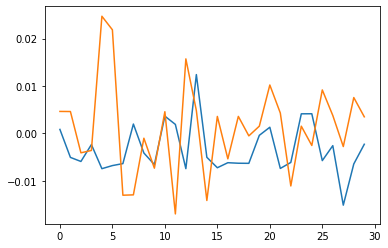

In [59]:
modelo_8 = tanise_model()
callback = EarlyStopping(monitor='loss', patience=10)
fitted_8 = modelo_8.fit(X_8train, y_8train, epochs = 150, batch_size = 80, callbacks=callback)
X_8test = []
y_8test = []
for i in range(456, len(X_8)):
    X_8test.append(X_8[i-30:i])
    y_8test.append(y_8[i])
X_8test = np.array(X_8test)
previsao_8 = modelo_8.predict(X_8test[:1])
plt.plot(previsao_8[0])
plt.plot(y_8test)


In [96]:
forecast_8 = previsao_8[0]
pfe_price_forecast = []
last = pfe_df.iloc[-1]['Close']
for i in forecast_8:
    last = last * (1 + i)
    print(last)
    pfe_price_forecast.append(last)
pfe_price_forecast

40.123880203672186
39.92107210987869
39.68516479186959
39.59187975436299
39.29763243338282
39.03123176377586
38.78290468860807
38.859688038193404
38.699255277620956
38.44525655264906
38.58540796312106
38.65882006819918
38.371636115612404
38.84779406176486
38.652180370888914
38.37263447867919
38.13578176562508
37.89615400932537
37.657252788342724
37.64224120422529
37.691411512995884
37.41317713388355
37.184406226735156
37.338255987291014
37.49317238259724
37.27824678772365
37.182210418609685
36.61993472548799
36.384275065252915
36.30121205540286


[40.123880203672186,
 39.92107210987869,
 39.68516479186959,
 39.59187975436299,
 39.29763243338282,
 39.03123176377586,
 38.78290468860807,
 38.859688038193404,
 38.699255277620956,
 38.44525655264906,
 38.58540796312106,
 38.65882006819918,
 38.371636115612404,
 38.84779406176486,
 38.652180370888914,
 38.37263447867919,
 38.13578176562508,
 37.89615400932537,
 37.657252788342724,
 37.64224120422529,
 37.691411512995884,
 37.41317713388355,
 37.184406226735156,
 37.338255987291014,
 37.49317238259724,
 37.27824678772365,
 37.182210418609685,
 36.61993472548799,
 36.384275065252915,
 36.30121205540286]

In [109]:
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_pfe = []
for i in range(1,31):
    final_array_pfe.append([i,y_8test[i-1]])
print(final_array_pfe)
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_pfer = []
for i in range(1,31):
    final_array_pfer.append([i,previsao_8[0][i-1]])
print(final_array_pfer)


[[1, 0.0046403789875584245], [2, 0.004618945330701063], [3, -0.004086841409350783], [4, -0.003590746302096992], [5, 0.024710500305666905], [6, 0.02185377799229271], [7, -0.013028485135715306], [8, -0.0129514430386386], [9, -0.0010093594360138791], [10, -0.007325105188421888], [11, 0.004580160525958332], [12, -0.016970571851920524], [13, 0.01571751543595923], [14, 0.004819950538605955], [15, -0.014137878431253248], [16, 0.003585131687161791], [17, -0.005358486650457017], [18, 0.0035915698125328355], [19, -0.0005112591592475457], [20, 0.0015345620366389312], [21, 0.010214543601571036], [22, 0.004297223534984074], [23, -0.011074720155514473], [24, 0.0015270439601855479], [25, -0.0025412573824329376], [26, 0.009171990072651237], [27, 0.0037868646521161953], [28, -0.0027665191221782903], [29, 0.0075661847544883365], [30, 0.003504365130784004]]
[[1, 0.0008450998], [2, -0.0050545484], [3, -0.0059093433], [4, -0.0023506274], [5, -0.007432012], [6, -0.0067790514], [7, -0.006362266], [8, 0.00197

y_8test = [0.0046403789875584245,
 0.004618945330701063,
 -0.004086841409350783,
 -0.003590746302096992,
 0.024710500305666905,
 0.02185377799229271,
 -0.013028485135715306,
 -0.0129514430386386,
 -0.0010093594360138791,
 -0.007325105188421888,
 0.004580160525958332,
 -0.016970571851920524,
 0.01571751543595923,
 0.004819950538605955,
 -0.014137878431253248,
 0.003585131687161791,
 -0.005358486650457017,
 0.0035915698125328355,
 -0.0005112591592475457,
 0.0015345620366389312,
 0.010214543601571036,
 0.004297223534984074,
 -0.011074720155514473,
 0.0015270439601855479,
 -0.0025412573824329376,
 0.009171990072651237,
 0.0037868646521161953,
 -0.0027665191221782903,
 0.0075661847544883365,
 0.003504365130784004]

previsao_8[0] =array([ 0.0008451 , -0.00505455, -0.00590934, -0.00235063, -0.00743201,
       -0.00677905, -0.00636227,  0.00197982, -0.00412851, -0.0065634 ,
        0.00364548,  0.00190259, -0.00742868,  0.01240911, -0.00503539,
       -0.00723234, -0.00617244, -0.00628354, -0.0063041 , -0.00039864,
        0.00130625, -0.0073819 , -0.00611471,  0.00413748,  0.004149  ,
       -0.00573239, -0.0025762 , -0.01512217, -0.00643528, -0.00228294],
      dtype=float32)

Epoch 1/150
3/3 [==============================] - 7s 119ms/step - loss: 1.7888 - mae: 0.9292
Epoch 2/150
3/3 [==============================] - 0s 91ms/step - loss: 0.2168 - mae: 0.3040
Epoch 3/150
3/3 [==============================] - 1s 190ms/step - loss: 0.0109 - mae: 0.0768
Epoch 4/150
3/3 [==============================] - 0s 100ms/step - loss: 0.0035 - mae: 0.0443
Epoch 5/150
3/3 [==============================] - 0s 110ms/step - loss: 0.0028 - mae: 0.0390
Epoch 6/150
3/3 [==============================] - 0s 99ms/step - loss: 0.0025 - mae: 0.0357
Epoch 7/150
3/3 [==============================] - 0s 111ms/step - loss: 0.0023 - mae: 0.0338
Epoch 8/150
3/3 [==============================] - 0s 113ms/step - loss: 0.0022 - mae: 0.0328
Epoch 9/150
3/3 [==============================] - 1s 253ms/step - loss: 0.0022 - mae: 0.0324
Epoch 10/150
3/3 [==============================] - 0s 124ms/step - loss: 0.0021 - mae: 0.0321
Epoch 11/150
3/3 [==============================] - 0s 143ms/

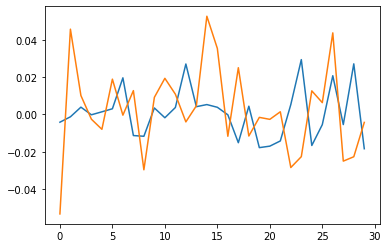

In [57]:
modelo_99 = tanise_model()
callback = EarlyStopping(monitor='loss', patience=10)
fitted_99 = modelo_99.fit(X_9train, y_9train, epochs = 150, batch_size = 180, callbacks=callback)
X_9test = []
y_9test = []
for i in range(547, len(X_9)):
    X_9test.append(X_9[i-30:i])
    y_9test.append(y_9[i])
X_9test = np.array(X_9test)
previsao_99 = modelo_99.predict(X_9test[:1])
plt.plot(previsao_99[0])
plt.plot(y_9test)

y_9test = [-0.05334473909669335,
 0.045754416082577576,
 0.010149431956828714,
 -0.0025448713746097917,
 -0.007968981170302758,
 0.0189384502913843,
 -0.00037694301217883197,
 0.012789171171239788,
 -0.029675107282609026,
 0.009193155866741742,
 0.019392564622878083,
 0.010882293607423321,
 -0.0039787272440097166,
 0.004638958818893091,
 0.052684715964052664,
 0.035411303807118655,
 -0.011694289843458106,
 0.025079220248551914,
 -0.011557615977613622,
 -0.0015570796512542895,
 -0.0026188454684518137,
 0.0014456595595533361,
 -0.028457809146336777,
 -0.02263560491364547,
 0.012657989351583465,
 0.006341837079579804,
 0.043762842630010734,
 -0.025025570765932037,
 -0.022676240229138833,
 -0.004254842933820169]

previsao_99[0] = array([-0.00414784, -0.00125644,  0.00391985, -0.00017305,  0.00142187,
        0.00305   ,  0.01965148, -0.01130714, -0.01169629,  0.0034886 ,
       -0.00176831,  0.00373249,  0.02706882,  0.00417263,  0.00530416,
        0.00385204, -0.00018047, -0.01515476,  0.00442669, -0.01779057,
       -0.01699155, -0.01420597,  0.00532681,  0.02941534, -0.01663947,
       -0.00546621,  0.02077877, -0.00541815,  0.02714775, -0.01838419],
      dtype=float32)

In [95]:
forecast_9 = previsao_99[0]
tsla_price_forecast = []
last = tsla_df.iloc[-1]['Close']
for i in forecast_9:
    last = last * (1 + i)
    print(last)
    tsla_price_forecast.append(last)
tsla_price_forecast

647.9013917631778
647.0873438523331
649.6238298467903
649.5114142717626
650.4349351950419
652.4187601946907
665.2397556399624
657.7177991467801
650.0249433321386
652.2926193038259
651.1391664180765
653.5695390462457
671.2608927238464
674.0618164708342
677.6371454122683
680.2474341430951
680.1246681065217
669.8175392325621
672.7826162090014
660.8134319115388
649.58518614373
640.3571973513683
643.7682553812668
662.704916999772
651.6778552471915
648.1156455968014
661.5826900812406
657.9981335268707
675.8613019871101
663.4361417287943


[647.9013917631778,
 647.0873438523331,
 649.6238298467903,
 649.5114142717626,
 650.4349351950419,
 652.4187601946907,
 665.2397556399624,
 657.7177991467801,
 650.0249433321386,
 652.2926193038259,
 651.1391664180765,
 653.5695390462457,
 671.2608927238464,
 674.0618164708342,
 677.6371454122683,
 680.2474341430951,
 680.1246681065217,
 669.8175392325621,
 672.7826162090014,
 660.8134319115388,
 649.58518614373,
 640.3571973513683,
 643.7682553812668,
 662.704916999772,
 651.6778552471915,
 648.1156455968014,
 661.5826900812406,
 657.9981335268707,
 675.8613019871101,
 663.4361417287943]

In [108]:

#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_tsla = []
for i in range(1,31):
    final_array_tsla.append([i,y_9test[i-1]])
print(final_array_tsla)
#fazer um array de 1 a 30;
#fazer um append para cada item do array
final_array_tslar = []
for i in range(1,31):
    final_array_tslar.append([i,previsao_99[0][i-1]])
print(final_array_tslar)



[[1, -0.05334473909669335], [2, 0.045754416082577576], [3, 0.010149431956828714], [4, -0.0025448713746097917], [5, -0.007968981170302758], [6, 0.0189384502913843], [7, -0.00037694301217883197], [8, 0.012789171171239788], [9, -0.029675107282609026], [10, 0.009193155866741742], [11, 0.019392564622878083], [12, 0.010882293607423321], [13, -0.0039787272440097166], [14, 0.004638958818893091], [15, 0.052684715964052664], [16, 0.035411303807118655], [17, -0.011694289843458106], [18, 0.025079220248551914], [19, -0.011557615977613622], [20, -0.0015570796512542895], [21, -0.0026188454684518137], [22, 0.0014456595595533361], [23, -0.028457809146336777], [24, -0.02263560491364547], [25, 0.012657989351583465], [26, 0.006341837079579804], [27, 0.043762842630010734], [28, -0.025025570765932037], [29, -0.022676240229138833], [30, -0.004254842933820169]]
[[1, -0.004147839], [2, -0.001256438], [3, 0.003919851], [4, -0.00017304718], [5, 0.0014218702], [6, 0.0030499976], [7, 0.019651482], [8, -0.011307136